## Predict Vex-seq on test

In [1]:
import kipoi
from kipoi.model import KerasModel
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline 

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import sys
sys.path.append("../")
from mmsplice.exon_dataloader import ExonDataset
from mmsplice.generic import get_var_side

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator HuberRegressor from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle

In [3]:
from kipoi.data import DataLoader
from kipoi.data_utils import numpy_collate

from keras.models import load_model
from concise.preprocessing import encodeDNA

%load_ext autoreload
%autoreload 2

expit = lambda x: 1./(1.+np.exp(-x))
from mmsplice.generic import logit

projectDIR = "../../data/"

In [4]:
dl = ExonDataset(projectDIR + "vexseq/HepG2_delta_PSI_CAGI_testing.csv",
           projectDIR + "shared/hg19.fa", split_seq=False, overhang=(100,80))

In [5]:
dl[33]

{'inputs': {'seq': 'ATTCTAAATGAATATCCTCCTATAATTAAACACATACACATACTCAGATTTGGTAATGTTTACCTTTCAAAATATATTGATATCTGTTTTATTTATATAGAGACTGATAAGGAACACTTAGCAGATGATACTGGAAGAGGTATAATAAAGGGATCAATCAATGCACAACTAAAGGGTCACCAAAGTAAGAAAAAGAATTTTTCACATCTAATATTTATGGCTGATTGATATTCCCTGAGTTAAATTAAGTATAGACCTTTAATA',
  'intronl_len': 100,
  'intronr_len': 80},
 'mut_inputs': {'seq': 'ATTCTAAATGAATATCCTCCTATAATTAAACACATACACATACTCAGATTTGGTAATGTTTAGCTTTCAAAATATATTGATATCTGTTTTATTTATATAGAGACTGATAAGGAACACTTAGCAGATGATACTGGAAGAGGTATAATAAAGGGATCAATCAATGCACAACTAAAGGGTCACCAAAGTAAGAAAAAGAATTTTTCACATCTAATATTTATGGCTGATTGATATTCCCTGAGTTAAATTAAGTATAGACCTTTAATA',
  'intronl_len': 100,
  'intronr_len': 80},
 'metadata': {'gene_id': '',
  'transcript_id': '',
  'biotype': '',
  'order': '',
  'ranges': GenomicRanges(chr='chr10', start=33134070, end=33134334, id='', strand='+')}}

In [6]:
dl = DataLoader(dl, batch_size=dl.__len__(), collate_fn=numpy_collate, shuffle=False)
dl = iter(dl)

In [7]:
dt = next(dl)

In [8]:
dt['inputs']['seq'][0][-80:]

'GTAGGAAACGCAAGAGATTCTGAAGCTTGAATTGTCTATATGTAGGTCTCTTGTGTGTTTTATTCTCCGCCCCTTCCCCC'

In [9]:
dt['inputs']['seq'][0][:100]

'TCAATCTAGGAAGGTTTGTCTGCTATTCATAAACTGCTTAAGATGTTTTCTTGTAGTTTGTGACATAAGCAGAACGCTTTGATTTGGTTTCTTTCTACAG'

In [10]:
csv = projectDIR + "vexseq/HepG2_delta_PSI_CAGI_testing.csv"
csvf = pd.read_csv(csv, sep=',')

In [11]:
csvf['side'] = list(map(get_var_side,
                         zip(csvf['hg19_variant_position'],
                             csvf['reference'],
                             csvf['variant'],
                             csvf['start'], csvf['end'],
                             csvf['strand'])))
csvf['REF_SEQ'] = dt['inputs']['seq']
csvf['ALT_SEQ'] = dt['mut_inputs']['seq']

## Prediction

In [ ]:
from mmsplice import MMSplice, predict_all, predict_all_table
from mmsplice.utils.postproc import transform
from mmsplice import EXON3

In [ ]:
model = MMSplice(
    exonM = EXON3,
    exon_cut_l=0,
    exon_cut_r=0,
    acceptor_intron_cut=6,
    donor_intron_cut=6,
    acceptor_intron_len=50,
    acceptor_exon_len=3,
    donor_exon_len=5,
    donor_intron_len=13)

In [ ]:
ref_pred = model.predict_on_unsplitted_batch(dt['inputs'])

alt_pred = model.predict_on_unsplitted_batch(dt['mut_inputs'])

X = alt_pred-ref_pred

delt_pred_sum = X.sum(1)
ref_psi = (csvf.HepG2_ref_psi/100.).as_matrix()
delt_pred_sum += logit(ref_psi)
delt_pred_sum = expit(delt_pred_sum)
delt_pred_sum -= ref_psi

In [ ]:
csvf["MMSplice_Delta_PSI_Pred_Sum"] = delt_pred_sum

In [ ]:
model = MMSplice(
    exon_cut_l=0,
    exon_cut_r=0,
    acceptor_intron_cut=6,
    donor_intron_cut=6,
    acceptor_intron_len=50,
    acceptor_exon_len=3,
    donor_exon_len=5,
    donor_intron_len=13)

In [ ]:
ref_pred = model.predict_on_unsplitted_batch(dt['inputs'])

alt_pred = model.predict_on_unsplitted_batch(dt['mut_inputs'])

X = alt_pred-ref_pred

delt_pred_sum = X.sum(1)
ref_psi = (csvf.HepG2_ref_psi/100.).as_matrix()
delt_pred_sum += logit(ref_psi)
delt_pred_sum = expit(delt_pred_sum)
delt_pred_sum -= ref_psi

In [ ]:
csvf["MMSplice_Delta_PSI_Pred_Sum3"] = delt_pred_sum

In [ ]:
X = transform(X)

In [ ]:
from sklearn.externals import joblib
huber = joblib.load(projectDIR + 'vexseq/scale_model.pkl')

In [ ]:
delt_pred = huber.predict(X)

In [ ]:
ref_psi = (csvf.HepG2_ref_psi/100.).as_matrix()
# ref_psi[ref_psi==0] = 0.001
delt_pred += logit(ref_psi)
delt_pred = expit(delt_pred)
delt_pred -= ref_psi

In [ ]:
csvf["MMSplice_Delta_PSI_Pred"] = delt_pred

In [ ]:
csvf.head()

# Plot test with true DPSI, compare methods

In [ ]:
test = pd.read_csv(projectDIR + "vexseq/Vexseq_HepG2_delta_PSI_CAGI_test_true.tsv", sep='\t')

In [ ]:
test.head()

In [ ]:
test.shape

## MMSplice

In [ ]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [ ]:
merged = test.merge(csvf, how='left')

In [ ]:
merged.head()

In [ ]:
r = pearsonr(merged['MMSplice_Delta_PSI_Pred'], merged['HepG2_delta_psi'])[0]

In [ ]:
merged.to_csv(projectDIR + "vexseq/MMSplice_test_pred.csv")

## HAL

In [34]:
hal = pd.read_csv(projectDIR + 'vexseq/HAL_test_pred.tsv', index_col=0)

In [35]:
hal['REF_SEQ'] = hal['REF_SEQ'].apply(lambda x: x[100:-74])
hal['ALT_SEQ'] = hal['ALT_SEQ'].apply(lambda x: x[100:-74])

In [36]:
hal.head()

,ID,REF_SEQ,ALT_SEQ,REF_PSI,PSI_PRED,SNP,DPSI_PRED,DPSI
0,chr10_114724268_T_C,,,89.024627,0.890246,False,1.110223e-16,-3.362128
1,chr10_114724279_A_G,,,89.024627,0.890246,False,1.110223e-16,-2.645510
2,chr10_114724280_T_G,,,89.024627,0.890246,False,1.110223e-16,-4.144964
3,chr10_114724285_A_C,,,89.024627,0.890246,False,1.110223e-16,-4.767620
4,chr10_114724289_C_A,,,89.024627,0.890246,False,1.110223e-16,-2.762261


Calculate correlation with only exonic variants and SNP

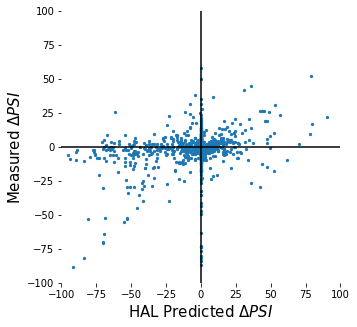

In [37]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axis([-100,100,-100,100])
ax.scatter(hal.DPSI_PRED*100, hal.DPSI, s=5)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.set_xlabel("HAL Predicted $\Delta PSI$", fontsize=15)
ax.set_ylabel("Measured $\Delta PSI$", fontsize=15)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## SPANR (Spidex)

sed 's/^chr//g' HepG2_delta_PSI_CAGI_training.vcf | bedtools intersect \

 -a spidex/hg19_spidex.txt -b - -header > Spidex_Train.txt

In [38]:
spidex = pd.read_csv(projectDIR + "vexseq/Spidex_Test.txt", sep='\t')

In [39]:
spidex['ID'] = "chr" + spidex['#Chr'].map(str) + "_" + \
spidex['Start'].map(str) + '_' + \
spidex['Ref'].map(str) + '_' + \
spidex['Alt'].map(str)

In [40]:
spidex = test.merge(spidex, on='ID', how='left')

In [41]:
sum(spidex.dpsi_max_tissue.isna())

132

In [42]:
spidex.head()

,ID,chromosome,hg19_variant_position,reference,variant,exon_start,exon_end,HepG2_delta_psi,#Chr,Start,End,Ref,Alt,dpsi_max_tissue,dpsi_zscore
0,chr10_114724268_T_C,chr10,114724268,T,C,114724315,114724383,-3.362128,10,114724268.0,114724268.0,T,C,-2.6303,-2.072
1,chr10_114724279_A_G,chr10,114724279,A,G,114724315,114724383,-2.645510,10,114724279.0,114724279.0,A,G,0.3341,0.939
2,chr10_114724279_A_G,chr10,114724279,A,G,114724315,114724383,-2.645510,10,114724279.0,114724279.0,A,G,0.3341,0.939
3,chr10_114724280_T_G,chr10,114724280,T,G,114724315,114724383,-4.144964,10,114724280.0,114724280.0,T,G,-2.1038,-1.934
4,chr10_114724285_A_C,chr10,114724285,A,C,114724315,114724383,-4.767620,10,114724285.0,114724285.0,A,C,2.4186,2.093


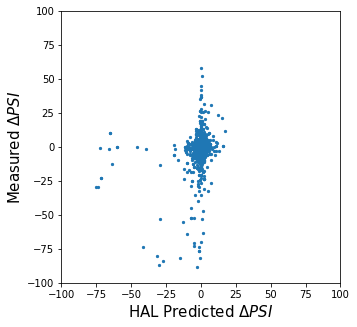

In [43]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axis([-100,100,-100,100])
ax.scatter(spidex.dpsi_max_tissue, spidex.HepG2_delta_psi, s=5)
ax.set_xlabel("HAL Predicted $\Delta PSI$", fontsize=15)
ax.set_ylabel("Measured $\Delta PSI$", fontsize=15)
plt.show()

In [44]:
spidex.to_csv(projectDIR + "vexseq/Spidex_Test_Pred.csv")

## MaxEnt

In [45]:
from copy import deepcopy
MaxEnt = deepcopy(csvf)
MaxEnt = MaxEnt[["ID","REF_SEQ", "ALT_SEQ","HepG2_ref_psi", "side"]]

In [46]:
MaxEnt.head(3)

,ID,REF_SEQ,ALT_SEQ,HepG2_ref_psi,side
0,chr10_114724268_T_C,TCAATCTAGGAAGGTTTGTCTGCTATTCATAAACTGCTTAAGATGT...,TCAATCTAGGAAGGTTTGTCTGCTATTCATAAACTGCTTAAGATGT...,89.024627,left
1,chr10_114724279_A_G,TCAATCTAGGAAGGTTTGTCTGCTATTCATAAACTGCTTAAGATGT...,TCAATCTAGGAAGGTTTGTCTGCTATTCATAAACTGCTTAAGATGT...,89.024627,left
2,chr10_114724280_T_G,TCAATCTAGGAAGGTTTGTCTGCTATTCATAAACTGCTTAAGATGT...,TCAATCTAGGAAGGTTTGTCTGCTATTCATAAACTGCTTAAGATGT...,89.024627,left


In [47]:
MaxEnt = test.merge(MaxEnt, on='ID', how='left')

In [48]:
MaxEnt['DONOR_REF'] = MaxEnt.REF_SEQ.apply(lambda x: x[-83:-74])
MaxEnt['DONOR_ALT'] = MaxEnt.ALT_SEQ.apply(lambda x: x[-83:-74])
MaxEnt['ACCEPTOR_REF'] = MaxEnt.REF_SEQ.apply(lambda x: x[80:103])
MaxEnt['ACCEPTOR_ALT'] = MaxEnt.ALT_SEQ.apply(lambda x: x[80:103])

In [49]:
from maxentpy import maxent
from maxentpy.maxent import load_matrix3, load_matrix5
matrix3 = load_matrix3()
matrix5 = load_matrix5()
from maxentpy import maxent_fast

In [50]:
MaxEnt['DONOR_DIFF'] = MaxEnt['DONOR_ALT'].apply(lambda x: maxent_fast.score5(x, matrix=matrix5)) - \
MaxEnt['DONOR_REF'].apply(lambda x: maxent_fast.score5(x, matrix=matrix5))

In [51]:
MaxEnt['ACCEPTOR_DIFF'] = MaxEnt['ACCEPTOR_ALT'].apply(lambda x: maxent_fast.score3(x, matrix=matrix3)) - \
MaxEnt['ACCEPTOR_REF'].apply(lambda x: maxent_fast.score3(x, matrix=matrix3))

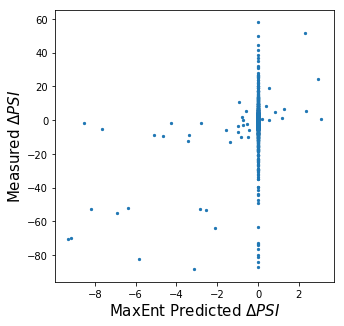

In [52]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.axis([-100,100,-100,100])
ax.scatter(MaxEnt.DONOR_DIFF, MaxEnt.HepG2_delta_psi, s=5)
ax.set_xlabel("MaxEnt Predicted $\Delta PSI$", fontsize=15)
ax.set_ylabel("Measured $\Delta PSI$", fontsize=15)
plt.show()

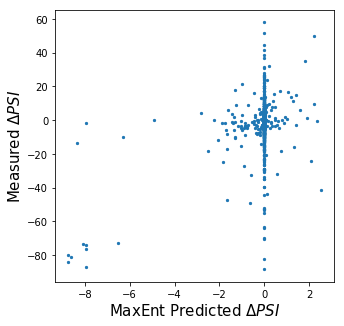

In [53]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.axis([-100,100,-100,100])
ax.scatter(MaxEnt.ACCEPTOR_DIFF, MaxEnt.HepG2_delta_psi, s=5)
ax.set_xlabel("MaxEnt Predicted $\Delta PSI$", fontsize=15)
ax.set_ylabel("Measured $\Delta PSI$", fontsize=15)
plt.show()

In [54]:
MaxEnt.to_csv(projectDIR + "vexseq/MaxEnt_Test_Pred.csv")